In [1]:
# leave this stuff alone (but run it)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import analysisTools
from datetime import datetime
from matplotlib import dates
import matplotlib.cm as cm

In [2]:
cd ~/Desktop/sara_2023-03-07/

/Users/iwoods/Desktop/sara_2023-03-07


# load the raw data
## takes awhile - could also load the .csv data saved by npy2csv (see below)

In [ ]:
# load the raw data ... takes awhile if lots of files (could skip to load binned data below)
start = datetime.now()
print('start loading data at: ' + start.strftime("%H:%M:%S"))
d = analysisTools.loadData('xy2')
finish = datetime.now()
diff = finish-start
print('finished at: ' + finish.strftime("%H:%M:%S"))
print('That took ' + str(diff.seconds) + '.' + str(diff.microseconds) + ' seconds')
print(np.shape(d)) # rows, columns. 
# Rows should be time (s) x 30 (framerate)
# Columns should be 2 x (# of individuals) + 1. 

In [ ]:
# convert XY data to distances
start = datetime.now()
print('start converting to distance at ' + start.strftime("%H:%M:%S"))
dist = analysisTools.convertXYDataToDistances(d) # takes awhile!
finish = datetime.now()
diff = finish-start
print('finished at ' + finish.strftime("%H:%M:%S"))
print('That took ' + str(diff.seconds) + '.' + str(diff.microseconds) + ' seconds')

In [ ]:
# bin the data into seconds or minutes
print('Binning data into seconds')
distsec, timesec = analysisTools.binData(dist,1)
print('Binning data into minutes')
distmin, timemin = analysisTools.binData(dist,60)
print(np.shape(distmin), np.shape(distsec))

In [ ]:
# which dataset do we want to look at (minute bins or second bins)
dataset = 'min' # 'min' or 'sec'
if dataset == 'sec':
    distances = distsec
    times = timesec
else:
    distances = distmin
    times = timemin

print(np.shape(distances), np.shape(times))
data = np.insert(distances,0,times,axis=1)
print(np.shape(data))

In [ ]:
# convert to pandas dataframe 
individuals = [str(i) for i in np.arange(1,13)]
cols = ['time'] + individuals
df = pd.DataFrame(data, columns = cols)
df.head(3)

# OR load the .csv data saved by npy2csv

In [4]:
# OR instead of loading raw data, and binning etc,
# load the binned distance data that was already made from npy2csv
individuals = [str(i) for i in np.arange(1,13)]
df = pd.read_csv('distances_230310-132439_60.csv', names=individuals, header=None)
t = np.genfromtxt('timeStamps_230310-132439_60.csv', dtype='str')
tnums = [dates.datestr2num(x[0] + ' ' + x[1]) for x in t]
df.insert(loc=0, column='time', value=tnums)

print(np.shape(df)) # rows, columns
# columns should be # of individuals
# rows should be time bins . . . 
df.head(5) # look at a bit of the data

(4433, 13)


,time,1,2,3,4,5,6,7,8,9,10,11,12
0,19423.479583,986.85,454.57,860.92,587.88,489.41,599.16,352.82,947.58,266.34,388.82,466.98,524.15
1,19423.480278,544.16,219.85,414.96,300.13,223.80,68.90,653.97,499.07,612.05,372.21,199.76,595.78
2,19423.480972,640.57,282.46,328.89,331.91,104.02,69.27,508.38,595.90,546.32,305.89,227.99,628.61
3,19423.481667,527.60,268.36,274.06,545.82,174.55,144.38,495.04,665.57,163.95,234.81,221.30,679.74
4,19423.482361,289.25,344.95,183.56,439.33,108.58,173.40,635.42,592.75,193.28,165.63,495.73,515.74


## Quality control

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']


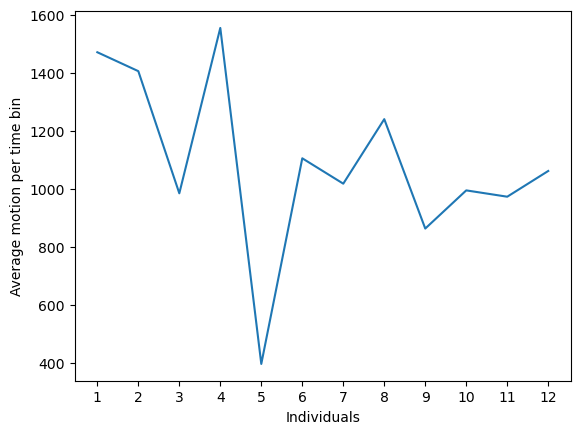

In [5]:
# show overall motion for individuals over experiment ... any outliers? dead?
print(individuals)
plt.plot(df[individuals].mean())
plt.xlabel('Individuals')
plt.ylabel('Average motion per time bin')
plt.show()

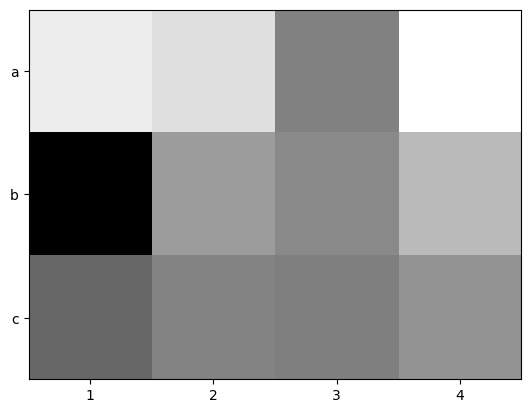

[[6518673.58 6229952.22 4364557.15 6890182.78]
 [1759115.   4899093.37 4511712.32 5497157.06]
 [3826347.19 4409209.19 4312692.7  4705667.06]]


In [6]:
# another look at overall activity in plate ... are there any dead individuals that should be omitted?
# is the difference in illumination across the plate causing big problems?
totalActivity = df[individuals].sum().values
plateView = np.reshape(totalActivity,(3,4))
plt.imshow(plateView, interpolation='nearest', cmap = 'gray')
columns = np.array([1,2,3,4])
rows = ['a','b','c']
plt.xticks(columns-1, columns)
plt.yticks([0,1,2],rows) # or other way?
plt.show()

print(plateView)

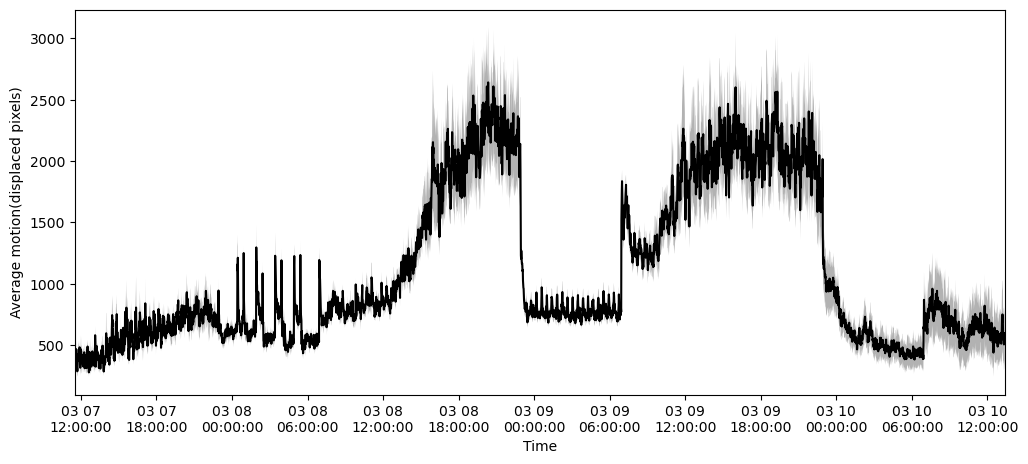

In [7]:
# ribbon plot of average motion
from matplotlib.ticker import MaxNLocator
def timeVdataRibbonPlot(ax,t,d,c, numticks=0): # axis, timeVec, data, color

    ax.plot(t,np.mean(d,axis=1),color=c)
    se = analysisTools.stde(d,1)
    ax.fill_between(t, np.mean(d,1)-se, np.mean(d,1)+se, alpha = 0.3, facecolor=c, edgecolor=None)
    ax.set_xlim([t[0],t[-1]])
    ax.xaxis.set_major_formatter( dates.DateFormatter('%m %d\n%H:%M:%S') )
    if numticks > 0:
        ax.xaxis.set_major_locator(MaxNLocator(numticks)) 
    return ax

d = df[individuals].values
t = df['time'].values
f,a = plt.subplots(figsize=(12,5))

a = timeVdataRibbonPlot(a,t,d,'k',15)
a.set_xlabel('Time')
a.set_ylabel('Average motion(displaced pixels)')
plt.show()

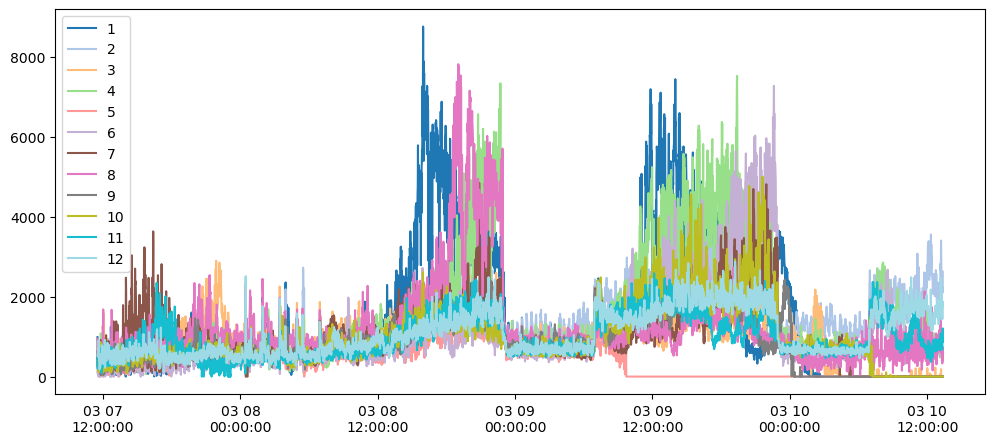

In [9]:
# plot activity of each individual in a different color
def multipleIndividualPlot(df, individuals):
    colormap = 'tab20'
    cols = analysisTools.make_N_colors(colormap, len(individuals))
    f,a = plt.subplots(figsize = (12,5))
    for i,individual in enumerate(individuals):
        plt.plot(df['time'].values, df[individual].values, color = cols[i] , label = individual)
    plt.legend()
    
    a.xaxis.set_major_formatter( dates.DateFormatter('%m %d\n%H:%M:%S') )
    plt.show()
    
multipleIndividualPlot(df,individuals)

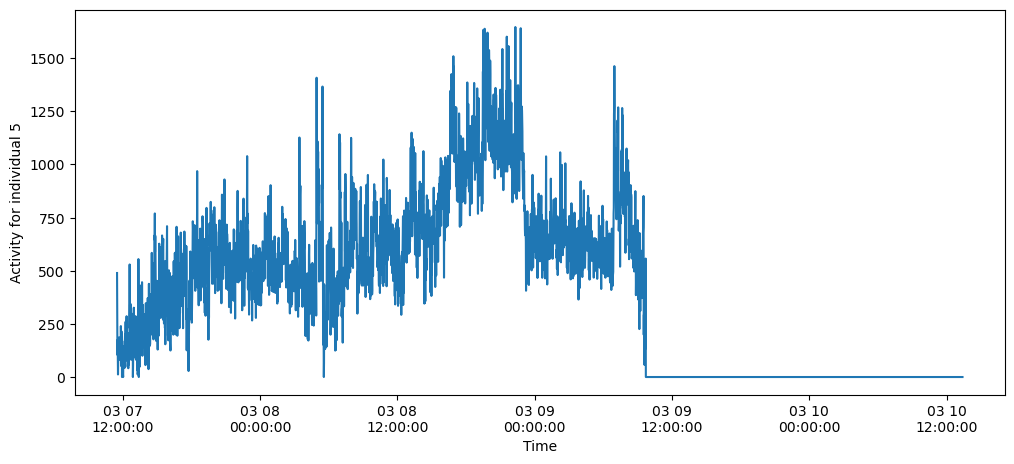

In [12]:
# plot a particular individual
def oneIndividualPlot(individual=1):
    selection = str(individual)
    f,a = plt.subplots(figsize = (12,5))
    plt.plot(df['time'].values, df[selection].values)
    plt.ylabel('Activity for individual ' + selection)
    plt.xlabel('Time')
    a.xaxis.set_major_formatter( dates.DateFormatter('%m %d\n%H:%M:%S') )
    plt.show()
    
oneIndividualPlot(5)

# Select subset of data based on time

In [13]:
def timeslice(df, startdate, starttime, duration):
    # duration is in minutes
#     startdate = str(year) + '-' + str(month) + '-' + str(day)
#     starttime = str(hour) + ':' + str(minute) + ':' + str(seconds)
    startdatetime = startdate + ' ' + starttime
    
    delta = duration / (60*24)
    startdatenum = dates.datestr2num(startdatetime)
    startdatetime = dates.num2date(startdatenum)
    enddatenum = startdatenum + delta
    enddatetime = dates.num2date(enddatenum)
    
    print('Start is ', startdatetime, ' which is ', str(startdatenum))
    print('End is   ', enddatetime, ' which is ', str(enddatenum))
    timeselection = df[df['time'].between(startdatenum,enddatenum)]
    return timeselection

Start is  2023-03-08 23:00:00+00:00  which is  19424.958333333332
End is    2023-03-09 08:00:00+00:00  which is  19425.333333333332


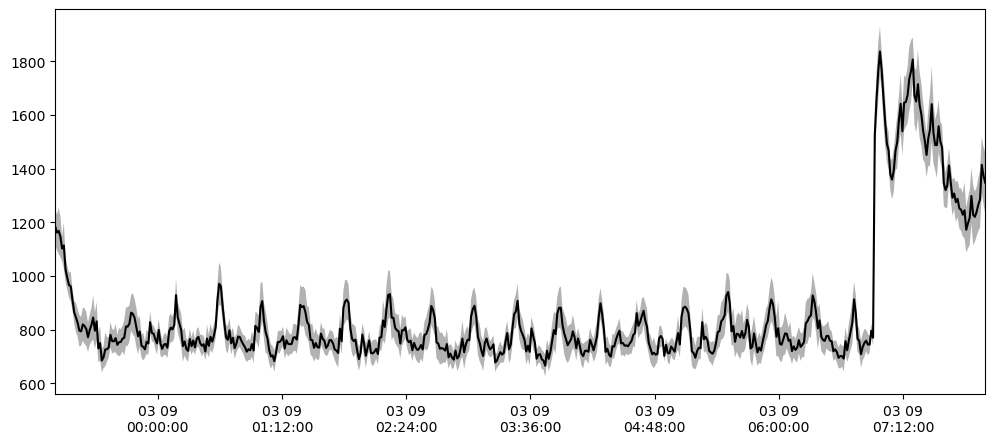

In [15]:
day = '2023-03-08'
time = '23:00:00'
duration = 540 # minutes ... 


ts = timeslice(df, day, time, duration)
d = ts[individuals].values
t = ts['time'].values
f,a = plt.subplots(figsize=(12,5))

a = timeVdataRibbonPlot(a,t,d,'k')#,15) # change number of ticks by including a number at end of arguments
plt.show()

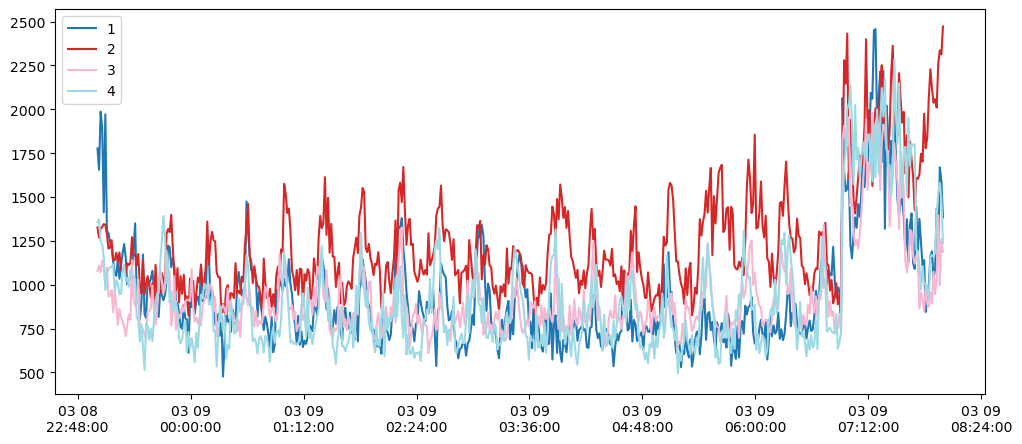

In [16]:
multipleIndividualPlot(ts,['1','2','3','4'])

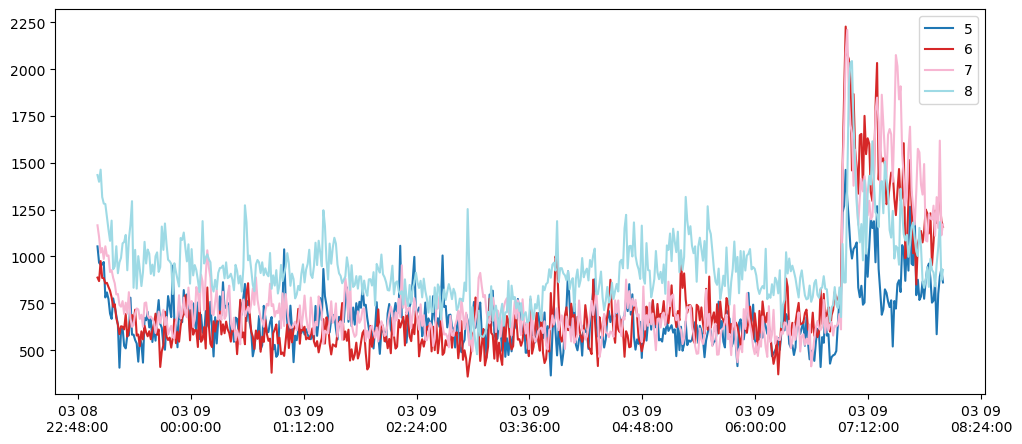

In [17]:
multipleIndividualPlot(ts,['5','6','7','8'])

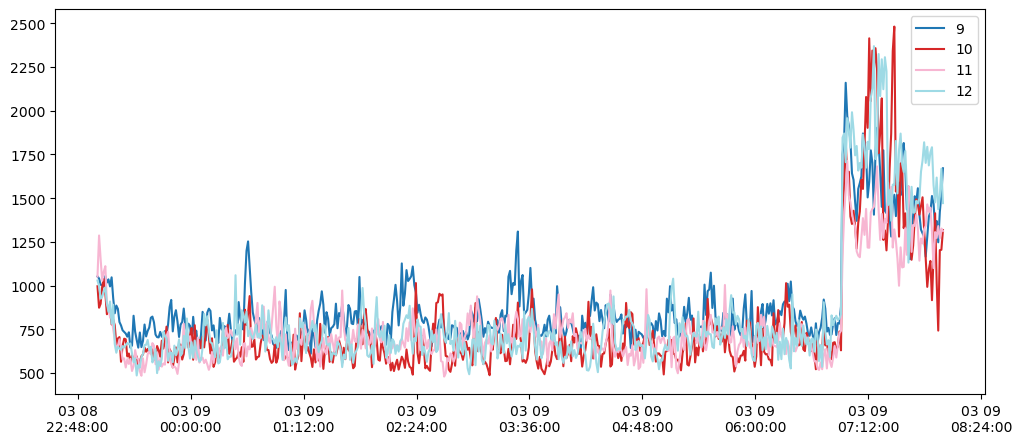

In [18]:
multipleIndividualPlot(ts,['9','10','11','12'])